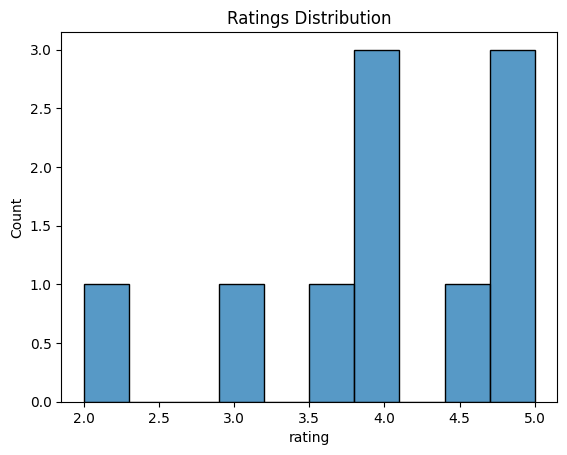

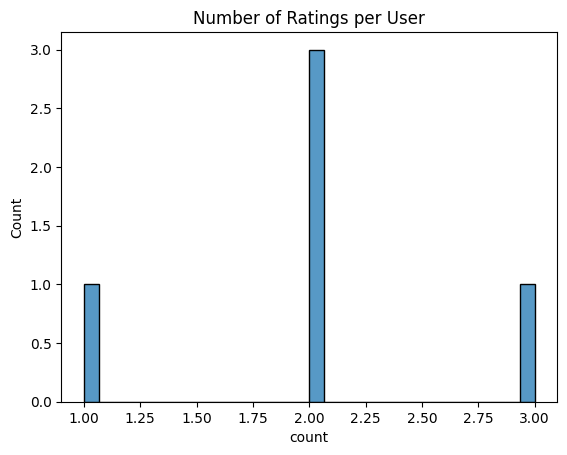

Random Forest RMSE: 1.4294676868087595
Random Forest R²: -2.632671764676241
KNN RMSE: 1.1423659658795862
KNN R²: -1.3199999999999994


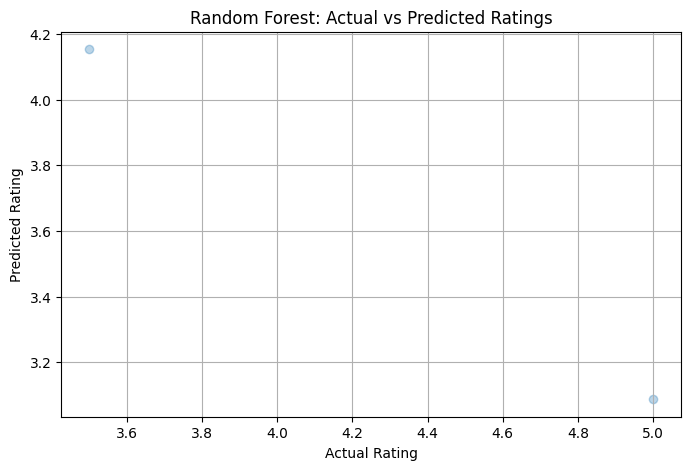

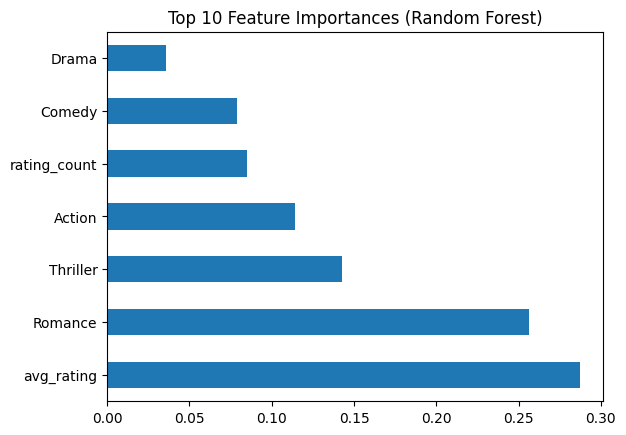

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

ratings.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)
ratings.dropna(inplace=True)
movies.dropna(inplace=True)

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings = ratings[(ratings['rating'] >= 0.5) & (ratings['rating'] <= 5)]

movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
all_genres = set(g for sublist in movies['genres'] for g in sublist)
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x))

sns.histplot(ratings['rating'], bins=10)
plt.title("Ratings Distribution")
plt.show()

user_rating_counts = ratings['userId'].value_counts()
sns.histplot(user_rating_counts, bins=30)
plt.title("Number of Ratings per User")
plt.show()

movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'rating_count']
movies = movies.merge(movie_stats, on='movieId', how='left')
movies.fillna(0, inplace=True)

movies.drop(['genres'], axis=1, inplace=True)

data = ratings.merge(movies, on='movieId')

features = data.drop(columns=['userId', 'movieId', 'title', 'timestamp', 'rating'])
target = data['rating']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
knn = KNeighborsRegressor(n_neighbors=5)

rf.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

rf_preds = rf.predict(X_test_scaled)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R²:", r2_score(y_test, rf_preds))

knn_preds = knn.predict(X_test_scaled)
print("KNN RMSE:", np.sqrt(mean_squared_error(y_test, knn_preds)))
print("KNN R²:", r2_score(y_test, knn_preds))

plt.figure(figsize=(8, 5))
plt.scatter(y_test, rf_preds, alpha=0.3)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Random Forest: Actual vs Predicted Ratings")
plt.grid()
plt.show()

importances = pd.Series(rf.feature_importances_, index=features.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()
